The purpose of this code is to count the number of circular droplets in each image and calculate their sizes.

Import Libraries

In [18]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.filters import gaussian, threshold_otsu, threshold_multiotsu
from skimage.measure import label, regionprops
from skimage.morphology import remove_small_objects, binary_dilation, disk, binary_closing
from scipy.signal import find_peaks
import czifile
import skimage.io as io
from skimage import exposure
from cellpose import models
from readlif.reader import LifFile
import cv2
model = models.Cellpose(model_type='cyto')

c:\Users\yh1024\Documents\Yiming Huang\.venv\Lib\site-packages\cellpose\resnet_torch.py:275: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(filename, 

In [19]:
def show_image(image):
    io.imshow(image, cmap='gray')
    plt.show()
    
def preprocess_green_channel(green_channel):
    """Preprocess the green channel for inclusion quantification."""
    confocal_img = gaussian(green_channel, sigma=2)
    confocal_img = exposure.adjust_sigmoid(green_channel, cutoff=0.25)
    confocal_img = (confocal_img - confocal_img.min()) / (confocal_img.max() - confocal_img.min())
    return confocal_img


def otsu_thresholding(channel):
    """Apply Otsu's thresholding and morphological closing to the channel."""
    threshold_value = threshold_otsu(channel)
    binary_image = channel > threshold_value
    # show_image(binary_image)
    closed_image = binary_closing(binary_image, disk(3))
    labeled_image = label(closed_image)
    return labeled_image

def calculate_circularity(region):
    """Calculate the circularity of a region."""
    return 4 * np.pi * region.area / region.perimeter ** 2


In [20]:
def analyze_all_images(dataset_path, exclude_images=[]):
    # read the dataset
    dataset = LifFile(dataset_path)
    img_list = [i for i in dataset.get_iter_image()]

    index = 0 # counter for image index
    image_indices = []
    image_indices2 = []
    droplet_counts = []
    droplet_sizes = []
    for img in img_list:
        if index in exclude_images:
            # skip this image
            image_indices.append(index)
            droplet_counts.append(0)
            index += 1  
            continue
        image_indices.append(index)
        frame = img.get_frame(z=0, t=0, c=0)

        # convert frame (Pillow image) to numpy array
        img_array = np.array(frame)
        show_image(img_array)

        blurred = gaussian(img_array, sigma=2)
        blurred = (blurred - blurred.min()) / (blurred.max() - blurred.min())

        # threshold using Otsu's method
        threshold_value = max(0.4, threshold_otsu(blurred))
        binary_image = blurred > threshold_value
        binary_image = binary_closing(binary_image, disk(3))
        show_image(binary_image)

        binary_image_labeled = label(binary_image)

        sizes = []
        for region in regionprops(binary_image_labeled):
            if region.area < 10 or region.area > 100000:
                 # ignore regions that are too small or too large
                 continue
            circularity = calculate_circularity(region)
            if circularity < 0.7 or circularity > 1.2:
                # ignore regions that are not circular
                continue
            sizes.append(region.area)
        droplet_sizes.append(sizes)
        droplet_counts.append(len(sizes))
        image_indices2.append([index] * len(sizes))
        index += 1

    # flatten image_indices2 and droplet_sizes
    image_indices2 = [item for sublist in image_indices2 for item in sublist]
    droplet_sizes = [item for sublist in droplet_sizes for item in sublist]

    # save results
    df1 = pd.DataFrame({
        "Image Index": image_indices,
        "Droplet Counts": droplet_counts
    })
    
    df2 = pd.DataFrame({
        "Image Index": image_indices2,
        "Droplet Index": range(len(droplet_sizes)),
        "Droplet Size": droplet_sizes
    })
    df1.to_excel(f"droplet_counts {dataset_path}.xlsx", index=False)
    df2.to_excel(f"droplet_sizes {dataset_path}.xlsx", index=False)
    



In [21]:
datasets = ['A140C 3K+asyn 3K PD.lif','A140C 3K+asyn 3K chloroquine.lif','A140C 3K+asyn WT chloroquine.lif','A140C 3K+asyn WT PD.lif']

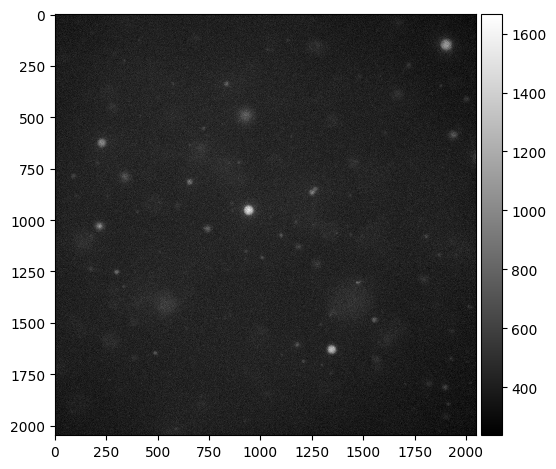

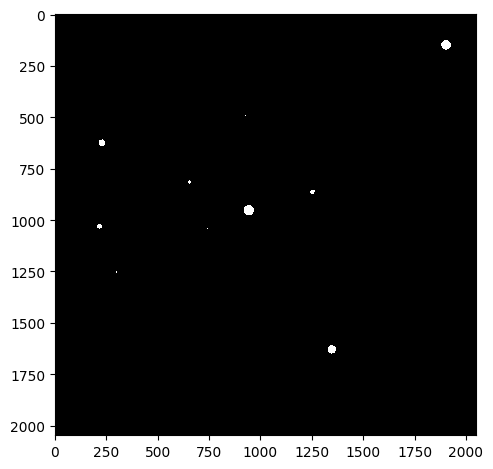

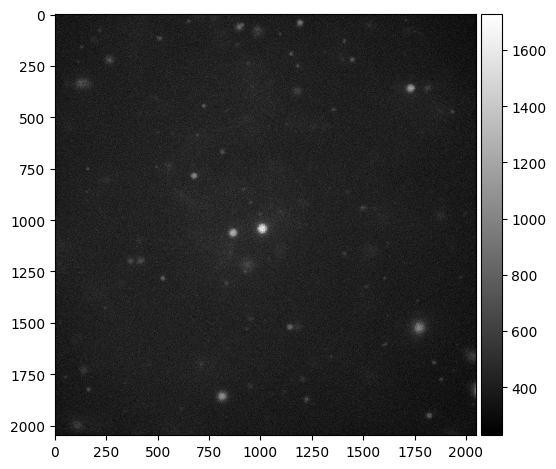

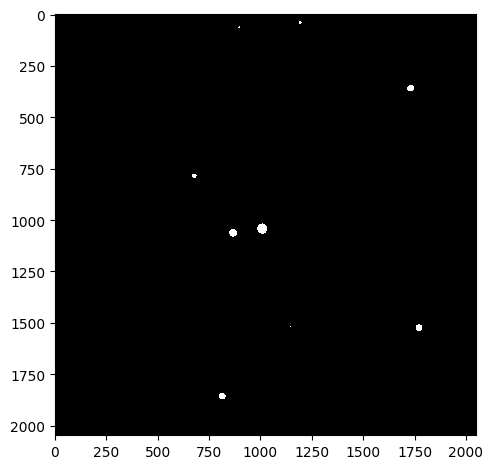

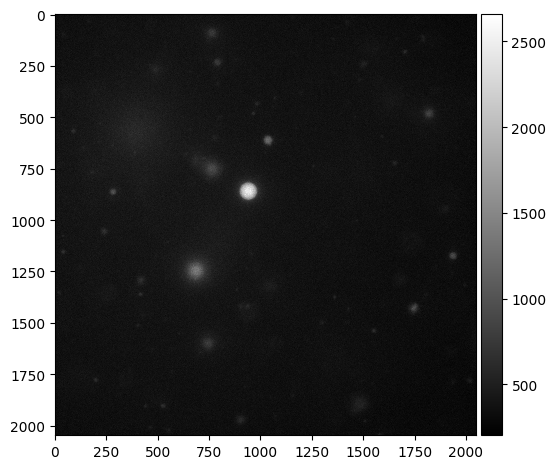

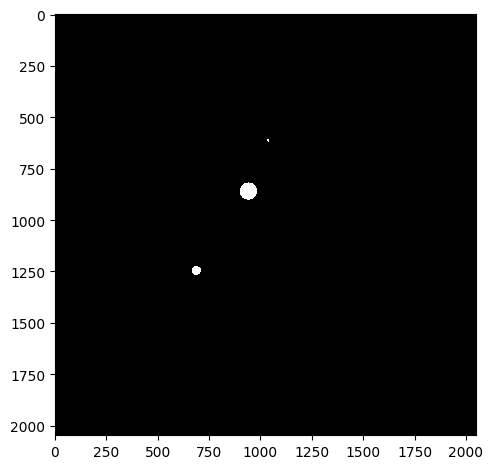

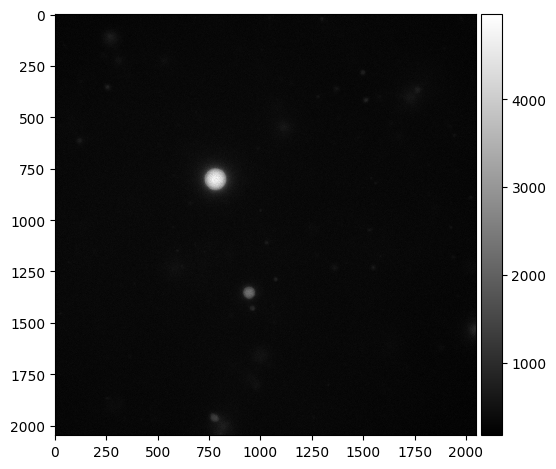

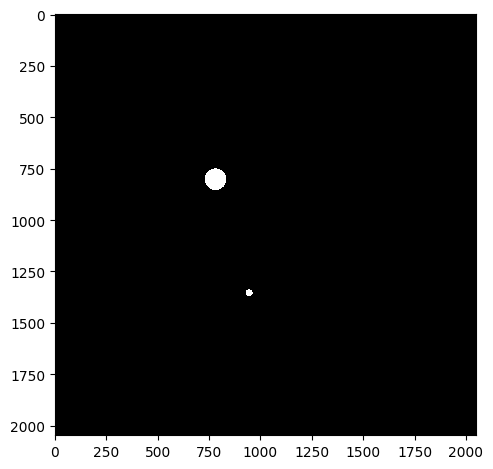

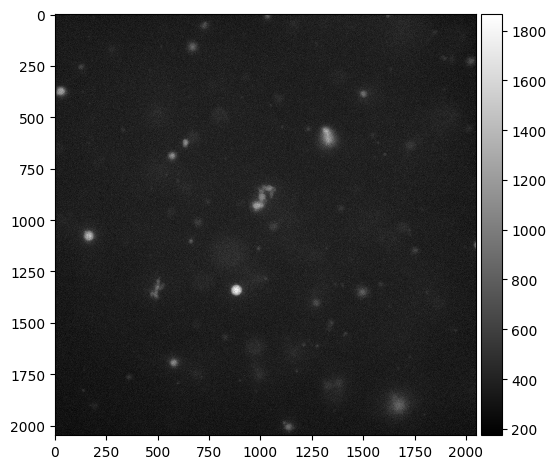

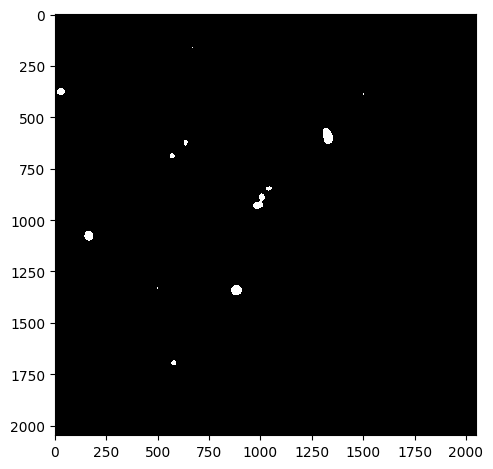

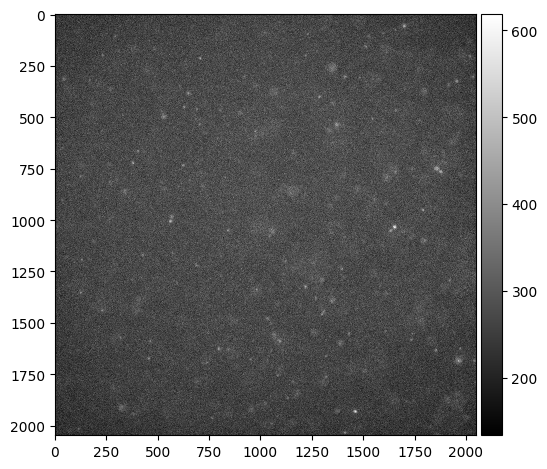

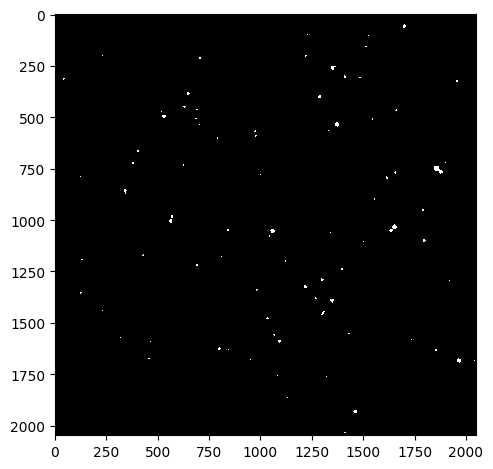

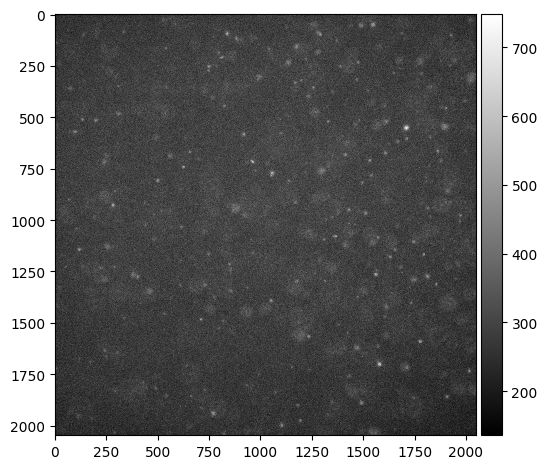

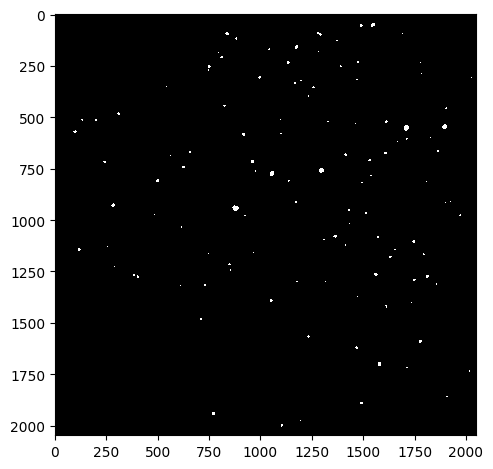

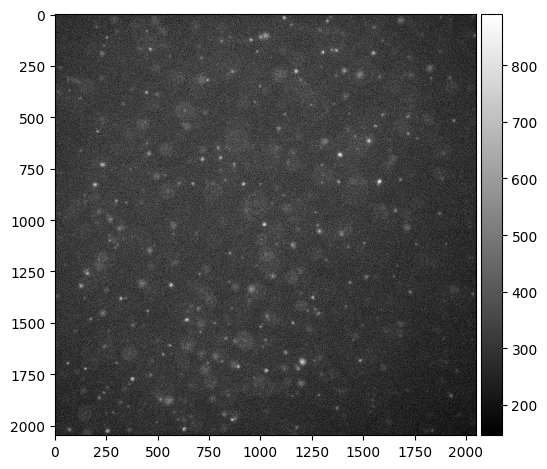

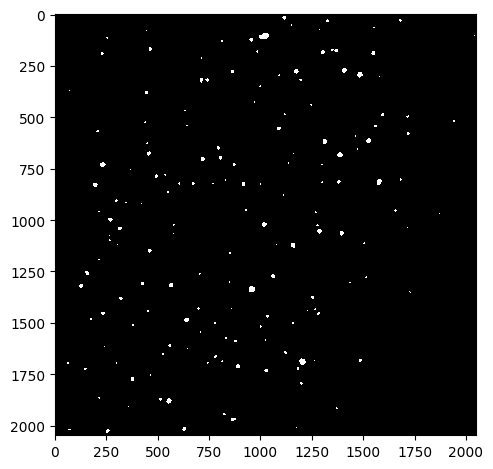

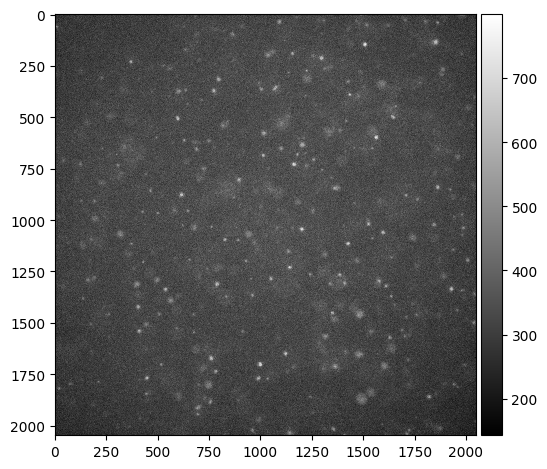

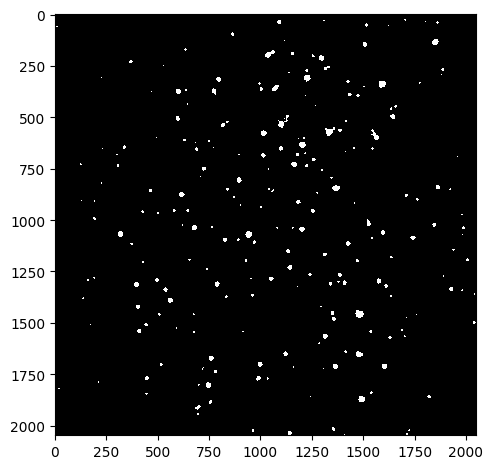

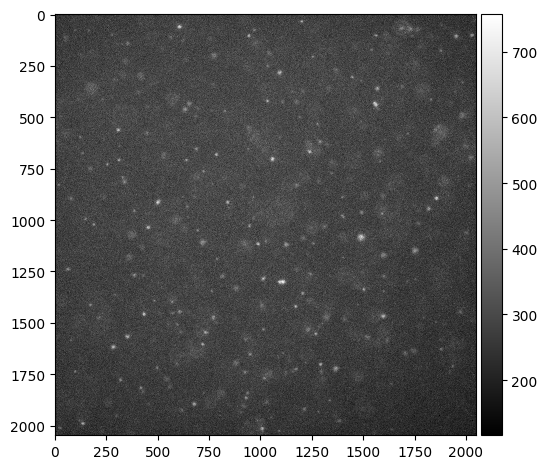

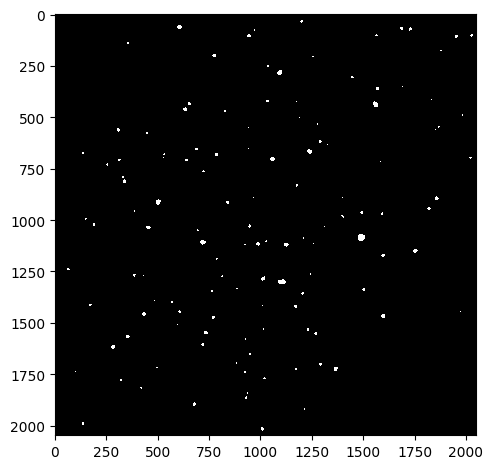

In [25]:
analyze_all_images(datasets[3])